# Topic 3
## Classification, Decision Trees, and k Nearest Neighbors

## Library imports

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

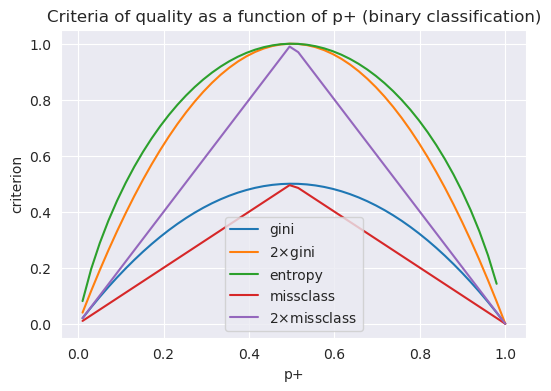

In [2]:
%%capture --no-displa
plt.figure(figsize=(6, 4))
xx = np.linspace(0.01, 1, 50)
plt.plot(xx, [2 * x * (1 - x) for x in xx], label="gini")
plt.plot(xx, [4 * x * (1 - x) for x in xx], label=r"2$\times$gini")
plt.plot(xx, [-x * np.log2(x) - (1 - x) * np.log2(1 - x) for x in xx], label="entropy")
plt.plot(xx, [1 - max(x, 1 - x) for x in xx], label="missclass")
plt.plot(xx, [2 - 2 * max(x, 1 - x) for x in xx], label=r"2$\times$missclass")
plt.xlabel("p+")
plt.ylabel("criterion")
plt.title("Criteria of quality as a function of p+ (binary classification)")
plt.legend()
plt.show()

## Example

Let's consider fitting a decision tree to some synthetic data. We will generate samples from two classes, both normal distributions but with different means.

In [3]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

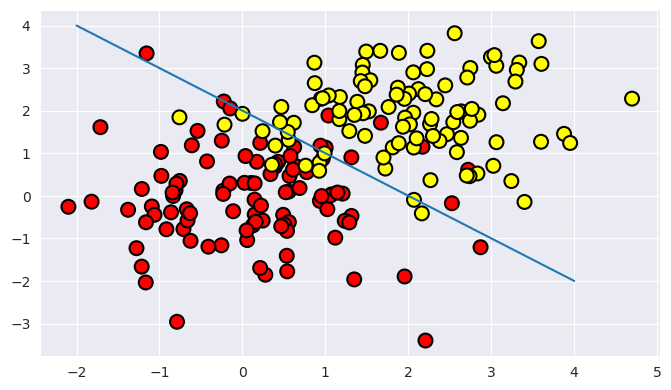

In [4]:
plt.figure(figsize=(8, 4.5))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)
plt.plot(range(-2, 5), range(4, -3, -1));

Let's try to separate these two classes by training an Sklearn decision tree. We will use `max_depth` parameter that limits the depth of the tree. Let's visualize the resulting separating boundary.

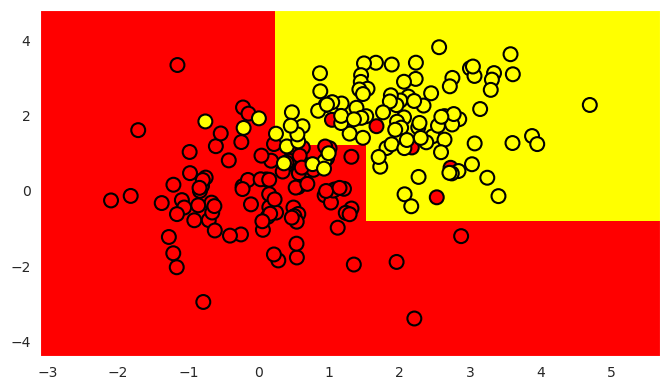

In [5]:
# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 4.5))
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)
plt.show()

In [6]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

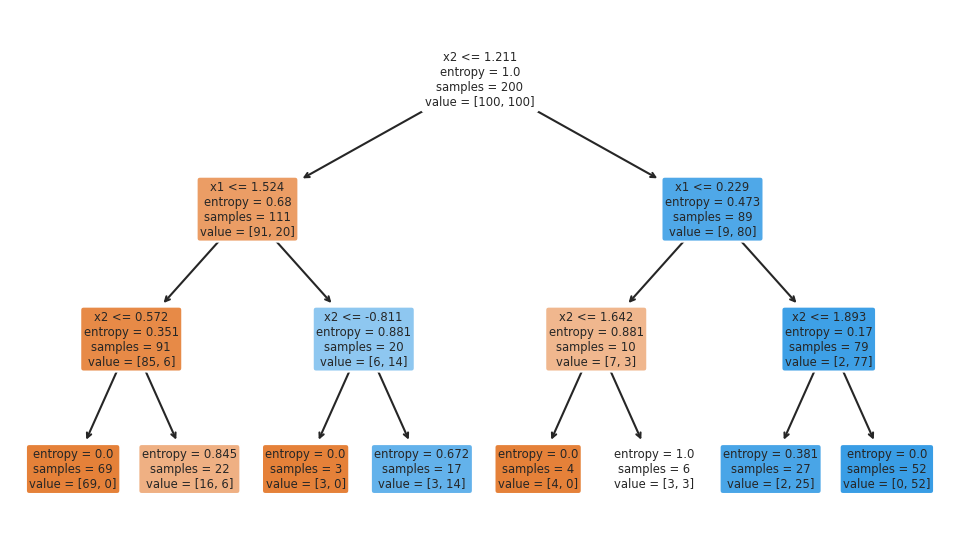

In [7]:
plt.figure(figsize=(8, 4.5), dpi=150)
plot_tree(clf_tree, feature_names=["x1", "x2"], filled=True, rounded=True)
plt.show()

### How a Decision Tree Works with Numerical Features

Suppose we have a numeric feature "Age" that has a lot of unique values. A decision tree will look for the best (according to some criterion of information gain) split by checking binary attributes such as "Age <17", "Age < 22.87", and so on. But what if the age range is large? Or what if another quantitative variable, "salary", can also be "cut" in many ways? There will be too many binary attributes to select from at each step during tree construction. To resolve this problem, heuristics are usually used to limit the number of thresholds to which we compare the quantitative variable.

Let's consider an example. Suppose we have the following dataset:

In [8]:
data = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data.head()

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1


In [9]:
data.sort_values("Age")

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


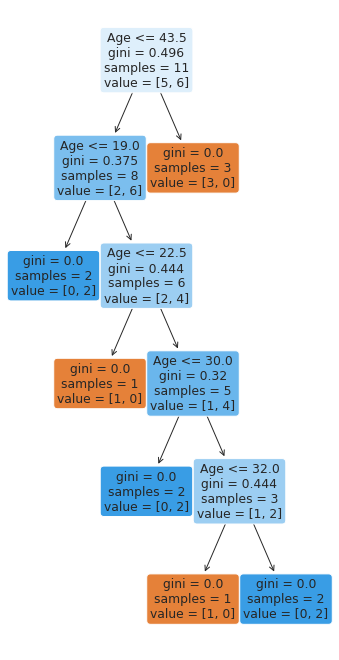

In [10]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data["Age"].values.reshape(-1, 1), data["Loan Default"].values)


plt.figure(figsize=(6, 12), dpi=70)
plot_tree(age_tree, feature_names=["Age"], filled=True, rounded=True)
plt.show()

### More complex example

In [11]:
data2 = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Salary": [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data2.sort_values("Age")

,Age,Salary,Loan Default
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [12]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[["Age", "Salary"]].values, data2["Loan Default"].values)

DecisionTreeClassifier(random_state=17)

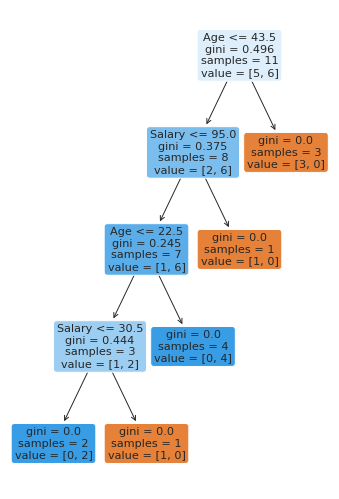

In [13]:
plt.figure(figsize=(6, 9), dpi=70)
plot_tree(age_sal_tree, feature_names=["Age", "Salary"], filled=True, rounded=True)
plt.show()

### Decision Tree in a Regression Problem

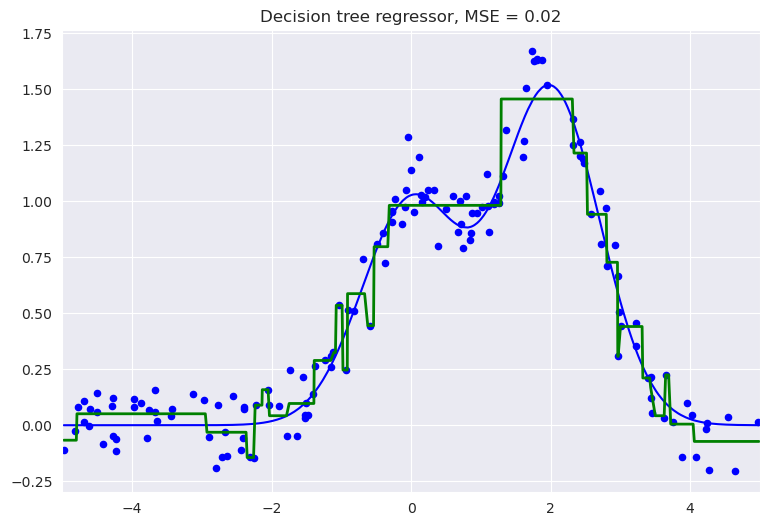

In [14]:
n_train = 150
n_test = 1000
noise = 0.1


def f(x):
    x = x.ravel()
    return np.exp(-(x ** 2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = (
        np.exp(-(X ** 2))
        + 1.5 * np.exp(-((X - 2) ** 2))
        + np.random.normal(0.0, noise, n_samples)
    )
    X = X.reshape((n_samples, 1))
    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(9, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title(
    "Decision tree regressor, MSE = %.2f"
    % (np.sum((y_test - reg_tree_pred) ** 2) / n_test)
)
plt.show()

## Nearest Neighbors Method

### Decision trees and nearest neighbors method in a customer churn prediction task

Let's read data into a DataFrame and preprocess it. Store State in a separate Series object for now and remove it from the dataframe. We will train the first model without the State feature, and then we will see if it helps.

In [15]:
df = pd.read_csv("../data/telecom-churn.csv")

df["International plan"] = pd.factorize(df["International plan"])[0]
df["Voice mail plan"] = pd.factorize(df["Voice mail plan"])[0]
df["Churn"] = df["Churn"].astype("int")
states = df["State"]
y = df["Churn"]
df.drop(["State", "Churn"], axis=1, inplace=True)

df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [16]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    df.values, y, test_size=0.3, random_state=17
)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)

# for kNN, we need to scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=10)

In [17]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.94

In [18]:
knn_pred = knn.predict(X_holdout_scaled)
accuracy_score(y_holdout, knn_pred)

0.89

In [19]:
tree_params = {"max_depth": range(1, 11), "max_features": range(4, 19)}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [20]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [21]:
tree_grid.best_score_ 

0.94257014456259

In [22]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

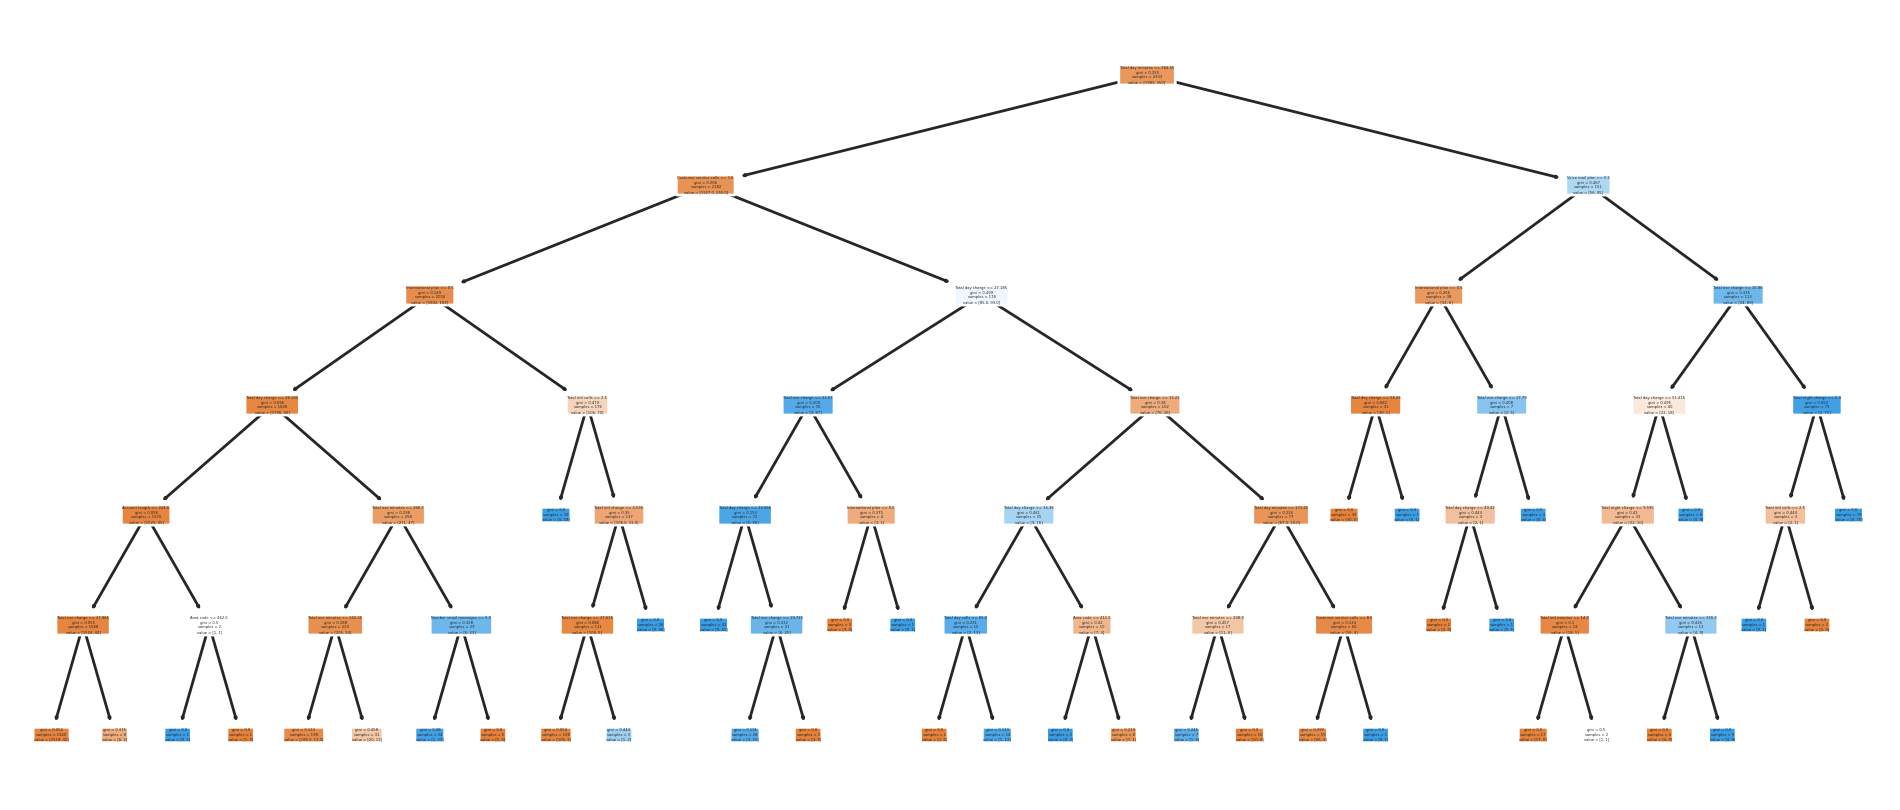

In [23]:
plt.figure(figsize=(12, 5), dpi=200)
plot_tree(tree_grid.best_estimator_, feature_names=df.columns, filled=True, rounded=True)
plt.show()

Now, let's tune the number of neighbors $k$ for k-NN:

In [24]:
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

knn_params = {"knn__n_neighbors": range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'knn__n_neighbors': 7}, 0.8859867109023905)

In [25]:
print(f'Accuracy score: {accuracy_score(y_holdout, knn_grid.predict(X_holdout))}')

Accuracy score: 0.89


In [26]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(f'CV score: {np.mean(cross_val_score(forest, X_train, y_train, cv=5))}') 

CV score: 0.9494233119813256


In [27]:
forest_params = {"max_depth": range(6, 12), "max_features": range(4, 19)}

forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(X_train, y_train)

forest_grid.best_params_, forest_grid.best_score_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


({'max_depth': 9, 'max_features': 6}, 0.9511372931045574)

In [28]:
print(f'Accuracy score: {accuracy_score(y_holdout, forest_grid.predict(X_holdout))}')

Accuracy score: 0.953


### Complex Case for Decision Trees

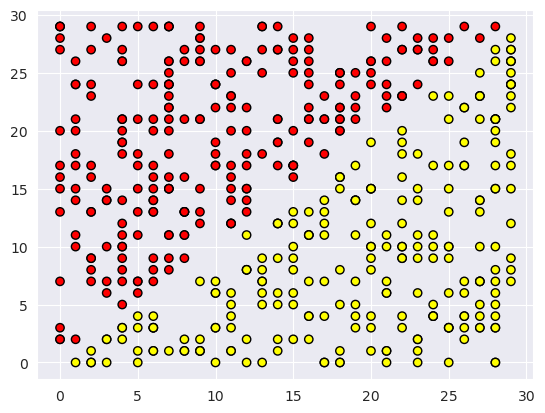

In [29]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1 = np.random.randint(x1_min, x1_max)
        x2 = np.random.randint(x2_min, x2_max)
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)


X, y = form_linearly_separable_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="autumn", edgecolors="black")
plt.show()

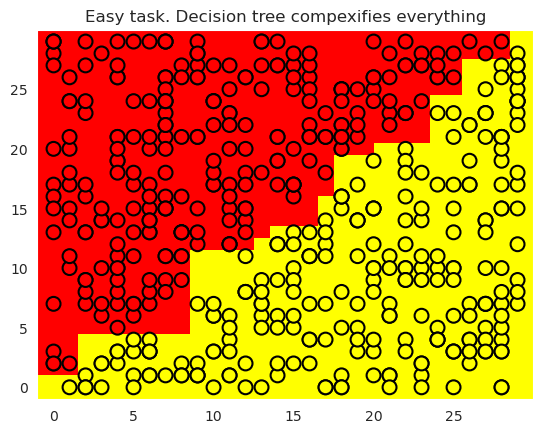

In [30]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    X[:, 0], X[:, 1], c=y, s=100, cmap="autumn", edgecolors="black", linewidth=1.5
)
plt.title("Easy task. Decision tree compexifies everything");

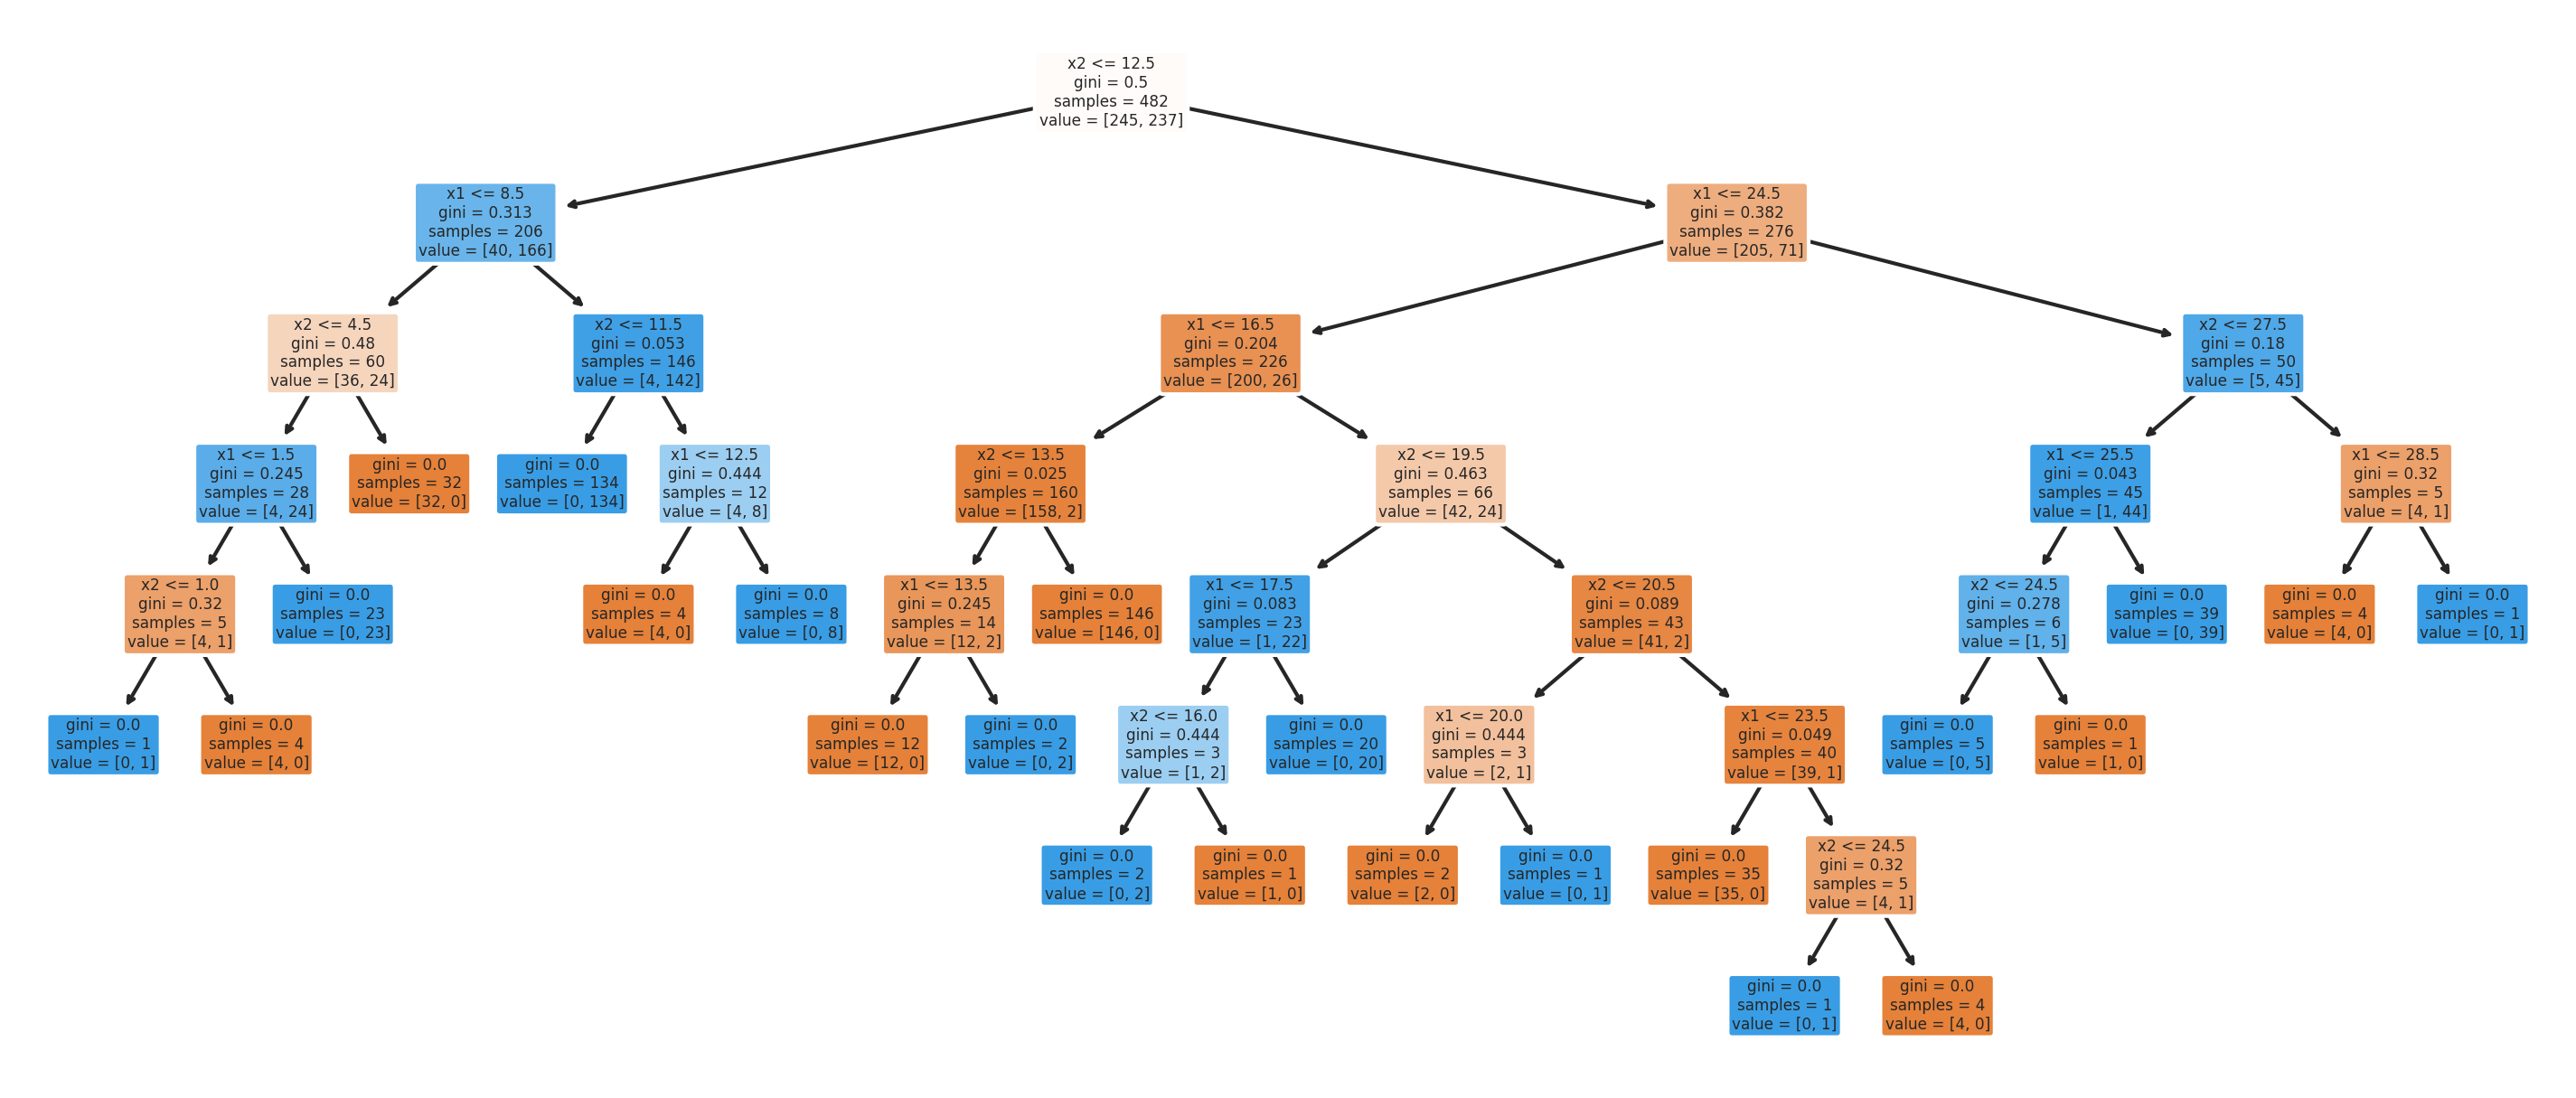

In [31]:
plt.figure(figsize=(12, 5), dpi=300)
plot_tree(tree, feature_names=["x1", "x2"], filled=True, rounded=True)
plt.show()

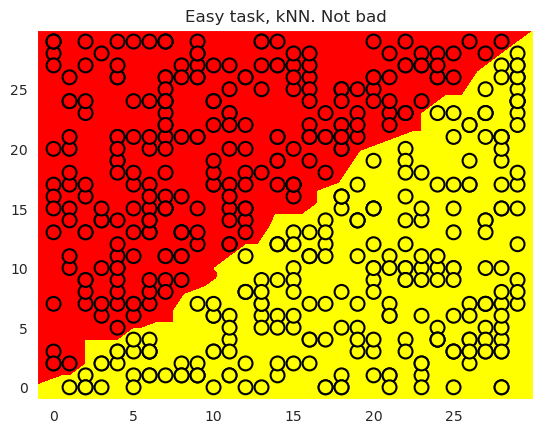

In [32]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    X[:, 0], X[:, 1], c=y, s=100, cmap="autumn", edgecolors="black", linewidth=1.5
)
plt.title("Easy task, kNN. Not bad");

## Decision Trees and k-NN in a Task of MNIST Handwritten Digits Recognition

Now let's have a look at how these 2 algorithms perform on a real-world task. We will use the sklearn built-in dataset on handwritten digits. This task is an example where k-NN works surprisingly well.

Pictures here are 8x8 matrices (intensity of white color for each pixel). Then each such matrix is "unfolded" into a vector of length 64, and we obtain a feature description of an object.

Let's draw some handwritten digits. We see that they are distinguishable.

In [33]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0, :].reshape([8, 8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

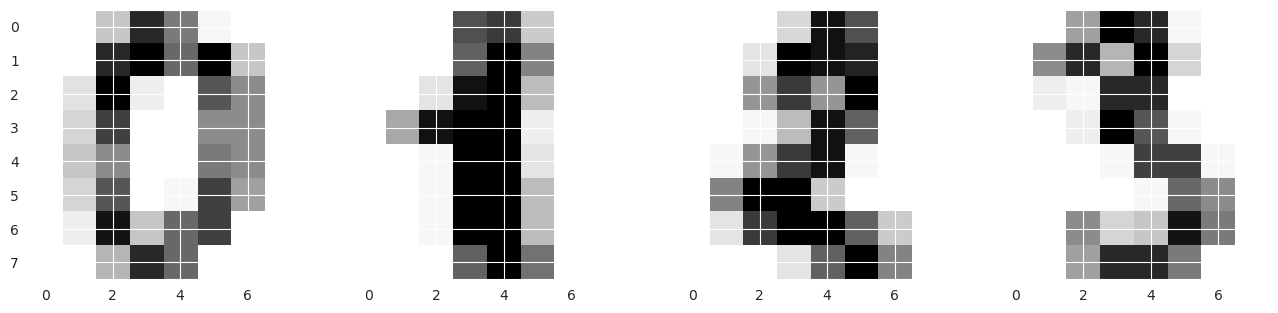

In [34]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 6))
for i in range(4):
    axes[i].imshow(X[i, :].reshape([8, 8]), cmap="Greys");

In [35]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [36]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=10))]
)

tree.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train);

In [37]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn_pipe.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(
    y_holdout, tree_pred
)  # (0.976, 0.666)

(0.975925925925926, 0.6666666666666666)

In [38]:
tree_params = {
    "max_depth": [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
    "max_features": [1, 2, 3, 5, 10, 20, 30, 50, 64],
}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

In [39]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

In [40]:
np.mean(
    cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5)
) 

0.9864858028204642

In [41]:
np.mean(
    cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5)
) 

0.9753462341111744

## Complex Case for the Nearest Neighbors Method

Let's consider another simple example. In the classification problem, one of the features will just be proportional to the vector of responses, but this won't help for the nearest neighbors method.